# SPLIT DATASET

I choose to use only the original dataset with duplicates and build two different training sets, one with duplicates and another without them. To compare the performance I use the same validation set.

Also the dataset without duplicates generates a vectorizated dataset witb duplicates, since two very similar asm files generate the same vector

In [1]:
#INPUT
DATASET_DUP = './dataset/vectorizated/DUP/dataset.json'

#OUTPUT
TRAINING_SET_DUP = './dataset_splitted/training_dup.json'
TRAINING_SET_NO_DUP = './dataset_splitted/training_no_dup.json'
VALIDATION_SET = './dataset_splitted/validation.json'

In [34]:
PERCENTAGE_VALIDATION_SET = 0.15    #usually is better 0.20 / 0.25 but in this case we have few unique sample

In [2]:
import json

In [36]:
def export_dataset_to_file(_path, _x_meaning, _y_meaning, _IDs, _X, _Y,):
    dataset_out_dict={} #dataset in dict format
    dataset_out_dict['x_meaning'] = _x_meaning
    dataset_out_dict['y_meaning'] = _y_meaning

    dataset_out_dict['dataset']=[]

    if (len(_IDs) != len(_X)) or (len(_X) != len(_Y)):
        print("Error, wrong dimensions")
        return None
  
    for idx in range(len(_X)):
        new_element = {}
        new_element['ID'] = _IDs[idx]
        new_element['x'] = _X[idx]
        new_element['y'] = _Y[idx]

        dataset_out_dict['dataset'].append(new_element)

    #write dataset_out_dict on json file
    file_dataset_out = open(_path, 'w')
    json.dump(dataset_out_dict, file_dataset_out)
    file_dataset_out.close()

In [3]:
def read_dataset(path):
    #load dataset
    file_dataset = open(path, 'r')
    dataset_json = json.load(file_dataset)

    x_meaning  = dataset_json['x_meaning']
    y_meaning  = dataset_json['y_meaning']

    #EXTRACT DATASET
    X = []
    Y = []
    IDs = []
    for elem in dataset_json['dataset']:
        X.append(elem['x'])
        Y.append(elem['y'])
        IDs.append(elem['ID'])

    dict_out = {}
    dict_out['x_meaning'] = x_meaning
    dict_out['y_meaning'] = y_meaning
    dict_out['IDs'] = IDs
    dict_out['X'] = X 
    dict_out['Y'] = Y

    file_dataset.close()
    return dict_out

## Create dataset without duplicates

In [4]:
import pandas as pd

In [5]:
dataset_duplicates = read_dataset(DATASET_DUP)
X = dataset_duplicates['X']
Y = dataset_duplicates['Y']
IDs = dataset_duplicates['IDs']
X_df = pd.DataFrame(X)
duplicates = X_df.duplicated()
duplicates.head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [40]:
X_no_duplicate = []
Y_no_duplicate = []
IDs_no_duplicate = []

idx = 0
for is_duplicate in duplicates:
    if not is_duplicate:
        X_no_duplicate.append(X[idx])
        Y_no_duplicate.append(Y[idx])
        IDs_no_duplicate.append(IDs[idx])
    idx = idx+1

In [41]:
#check no duplicates
for i in pd.DataFrame(X_no_duplicate).duplicated():
    if i:
        print(i)

## Analysis distribution of classes

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import numpy as np

In [7]:
# source: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
def plt_pie_chart(title, data, labels):
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

    new_label = labels
    sum_data = sum(data)
    for i in range(0,len(new_label)):
        new_label[i] = new_label[i] + ": " + str(data[i]) + ' (' + "%.2f" % ((data[i]/sum_data)*100) + '%)' 
    
    wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(new_label[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    ax.set_title(title+'\n')

    plt.show()

In [9]:
def get_distribution_classes(ground_truths):
    res = [0,0,0,0,0] #first element is useless, it indicates a sample without label
    for elem in ground_truths:
        res[elem] = res[elem]+1
    return res 

### Dataset with NO duplications

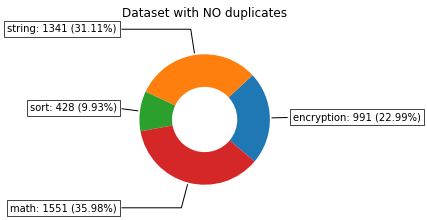

In [45]:
distribution = get_distribution_classes(Y_no_duplicate)
plt_pie_chart('Dataset with NO duplicates', distribution[1:], dataset_duplicates['y_meaning'][1:])

## Build Validation set and Training_set_with_NO_Duplicates

In [46]:
from sklearn.utils import shuffle

In [47]:
dataset_duplicates['y_meaning']

['undefined', 'encryption', 'string', 'sort', 'math']

In [48]:
#separate each sample according to class
element_for_class = {
    0:[],
    1:[],
    2:[],
    3:[],
    4:[]
}
for idx in range(len(Y_no_duplicate)):
    element_for_class[Y_no_duplicate[idx]].append(idx)
    
len(element_for_class[0]), len(element_for_class[1]), len(element_for_class[2]),  len(element_for_class[3]),  len(element_for_class[4])

(0, 991, 1341, 428, 1551)

In [49]:
idx_validation_set = []
idx_training_set = []

for classe in [1,2,3,4]:
    n_elem = len(element_for_class[classe])
    n_validation = int(PERCENTAGE_VALIDATION_SET*n_elem)
    idx_validation_set= idx_validation_set + element_for_class[classe][:n_validation]
    idx_training_set = idx_training_set + element_for_class[classe][n_validation:]

len(idx_training_set), len(idx_validation_set)

(3666, 645)

In [50]:
#need shuffle
idx_val_shuffle = shuffle(idx_validation_set, random_state=20201122)
idx_train_shuffle = shuffle(idx_training_set, random_state=20201122)

In [51]:
X_training = []
Y_training = []
IDs_training = []

for idx in idx_train_shuffle:
    X_training.append(X_no_duplicate[idx])
    Y_training.append(Y_no_duplicate[idx])
    IDs_training.append(IDs_no_duplicate[idx])

In [52]:
X_validation = []
Y_validation = []
IDs_validation = []

for idx in idx_val_shuffle:
    X_validation.append(X_no_duplicate[idx])
    Y_validation.append(Y_no_duplicate[idx])
    IDs_validation.append(IDs_no_duplicate[idx])

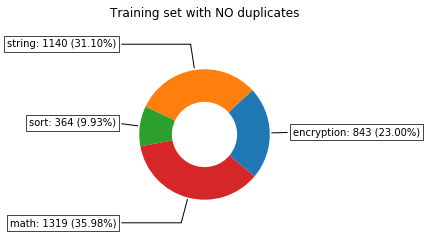

In [53]:
distribution = get_distribution_classes(Y_training)
plt_pie_chart('Training set with NO duplicates'+'\n', distribution[1:], dataset_duplicates['y_meaning'][1:])

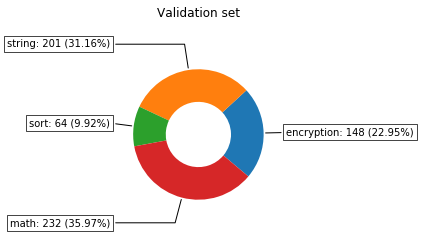

In [54]:
distribution = get_distribution_classes(Y_validation)
plt_pie_chart('Validation set'+'\n', distribution[1:], dataset_duplicates['y_meaning'][1:])

## Build training set with duplicates

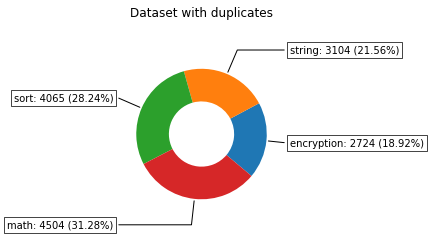

In [11]:
distribution = get_distribution_classes(Y)
plt_pie_chart('Dataset with duplicates'+'\n', distribution[1:], dataset_duplicates['y_meaning'][1:])

In [55]:
#remove from training set the instance that there is in the validation set
X_training_dup = []
Y_training_dup = []
IDs_training_dup = []

for idx in range(len(X)):
    if not (X[idx] in X_validation):
        X_training_dup.append(X[idx])
        Y_training_dup.append(Y[idx])
        IDs_training_dup.append(IDs[idx])

X_training_dup_SHUFFLED, Y_training_dup_SHUFFLED, IDs_training_dup_SHUFFLED = shuffle(X_training_dup, Y_training_dup, IDs_training_dup, random_state=20201122)

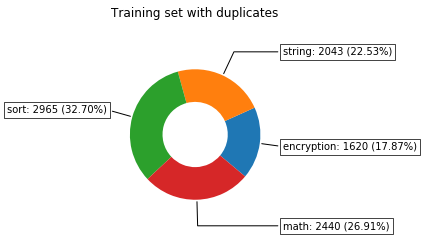

In [56]:
distribution = get_distribution_classes(Y_training_dup_SHUFFLED)
plt_pie_chart('Training set with duplicates'+'\n', distribution[1:], dataset_duplicates['y_meaning'][1:])

# EXPORT DATASETS

In [57]:
TRAINING_SET_DUP = './dataset_splitted/training_dup.json'
TRAINING_SET_NO_DUP = './dataset_splitted/training_no_dup.json'
VALIDATION_SET = './dataset_splitted/validation.json'

In [58]:
x_meaning = dataset_duplicates['x_meaning']
y_meaning = dataset_duplicates['y_meaning']

export_dataset_to_file(TRAINING_SET_DUP, x_meaning, y_meaning, IDs_training_dup_SHUFFLED, X_training_dup_SHUFFLED, Y_training_dup_SHUFFLED)

export_dataset_to_file(TRAINING_SET_NO_DUP, x_meaning, y_meaning, IDs_training, X_training, Y_training)

export_dataset_to_file(VALIDATION_SET, x_meaning, y_meaning, IDs_validation, X_validation, Y_validation)

## CHECKS

In [59]:
train_DUP = read_dataset(TRAINING_SET_DUP)
train_DUP['X'] == X_training_dup_SHUFFLED, train_DUP['Y'] == Y_training_dup_SHUFFLED, train_DUP['IDs'] == IDs_training_dup_SHUFFLED

(True, True, True)

In [60]:
train = read_dataset(TRAINING_SET_NO_DUP)
train['X'] == X_training, train['Y'] == Y_training, train['IDs'] == IDs_training

(True, True, True)

In [61]:
val = read_dataset(VALIDATION_SET)
val['X'] == X_validation, val['Y'] == Y_validation, val['IDs'] == IDs_validation

(True, True, True)

## DUPLICATES?

In [62]:
#check no duplicates
for i in pd.DataFrame(train['X']).duplicated():
    if i:
        print(i)

In [63]:
#check no duplicates
for i in pd.DataFrame(val['X']).duplicated():
    if i:
        print(i)

In [64]:
for el in val['X']:
    if (el in train['X']) or (el in train_DUP['X']):
        print('error')